In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import scanpy.api as sc
import matplotlib.pyplot as plt
import seaborn
import itertools as it
import h5py

/home/anders/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [15]:
cnts = sc.read_h5ad( "Tabula_muris_10x.h5ad" )
cntsT = cnts.transpose()
cnts

AnnData object with n_obs × n_vars = 55656 × 23433 
    obs: 'tissue', 'channel', 'cell_ontology_class', 'cell_ontology_id', 'channel.y', 'cluster.ids', 'free_annotation', 'mouse.id', 'mouse.sex', 'subsetA', 'subsetA_cluster.ids', 'subsetB', 'subsetB_cluster.ids', 'subtissue', 'tissue_tSNE_1', 'tissue_tSNE_2', 'batch'

In [17]:
cnts.obs["endo_gold"] = ( cntsT["Pecam1",:].X > 3 ) & ( cntsT["Cdh5",:].X > 3 )

In [4]:
h5f = h5py.File( "sims.hdf5", "r" )
h5sim = h5f["sim_matrix"]

Find k nearest neighbors

In [106]:
k = 20
nn = np.empty( ( cnts.n_obs, k ), 'i' )
for i in range(cnts.n_obs):
    a = -h5sim[ i, : ]
    argpart = a.argpartition(k+1)[:(k+1)]
    nn[i,:] = argpart[ a[argpart].argsort() ][1:]
    if i % 1000 == 0:
        print( i, end=" " )

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 

In [124]:
h5sim[ 17, :][ nn[17,:] ]

array([0.79035735, 0.78237766, 0.7818002 , 0.77985215, 0.77924466,
       0.7786844 , 0.77856135, 0.778466  , 0.7772087 , 0.7770382 ,
       0.7768462 , 0.77671057, 0.7751286 , 0.77491343, 0.7721323 ,
       0.77098453, 0.7701637 , 0.76951057, 0.7690026 , 0.76895434],
      dtype=float32)

In [121]:
n_endo_gold_nghbrs = np.full( (cnts.n_obs,), -1 )
for i in range(cnts.n_obs):
    n_endo_gold_nghbrs[i] = cnts.obs.endo_gold[ nn[i,:10] ].sum()
    if i % 1000 == 0:
        print( i, end=" " )

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 

(array([  5.,   4.,   5.,  10.,  16.,  18.,  29.,  34.,  70., 206.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5]),
 <a list of 10 Patch objects>)

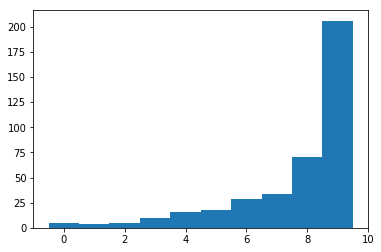

In [122]:
plt.hist( n_endo_gold_nghbrs[ cnts.obs.endo_gold ], bins=np.arange(-.5,10.5) )

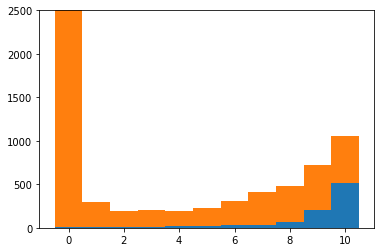

In [123]:
plt.hist( [ n_endo_gold_nghbrs[ cnts.obs.endo_gold ], n_endo_gold_nghbrs[ ~cnts.obs.endo_gold ] ],
        stacked=True, bins=np.arange(-.5,11.5) )
plt.ylim(0,2500);